In [1]:
# imports 
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api

2026-02-06 11:57:06.050596: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 11:57:06.062513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 11:57:06.471028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 11:57:07.884934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
import pandas as pd

def load_data():
    data_path = "dataset/data/labeled_data.csv"

    df = pd.read_csv(data_path, index_col=0)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

df = load_data()
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,@erinscafe Bu I do. I do hate the playa. And t...
1,3,0,3,0,1,"""@iDntWearCondoms: Watch women try to argue wi..."
2,3,1,2,0,1,Say it to me when I confront you pussy fuck
3,3,0,3,0,1,RT @Zag_OX: Your girl hold my dick like a wii ...
4,6,1,5,0,1,How she stay faithful with a room full of hoes


## Dataset variables
The two most important variables are **class** and **tweet**. The classification task’s goal is the `class` label, and predictions are made using the `tweet` text.

- `tweet` contains English text and may include informal grammar or special characters.
- Each tweet is cleaned and processed before modeling.

In [3]:


# Attempt to download required NLTK data (safe to re-run; may fail offline)
for resource in ["stopwords", "wordnet", "omw-1.4"]:
    try:
        nltk.data.find(f"corpora/{resource}")
    except LookupError:
        try:
            nltk.download(resource, quiet=True)
        except Exception:
            pass

# Stopwords (fallback if NLTK data unavailable)
try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    stop_words = {
        "a", "an", "the", "and", "or", "but", "if", "while", "is", "am", "are",
        "was", "were", "be", "been", "being", "to", "of", "in", "on", "for",
        "with", "at", "by", "from", "up", "down", "out", "over", "under",
        "again", "further", "then", "once", "here", "there", "when", "where",
        "why", "how", "all", "any", "both", "each", "few", "more", "most",
        "other", "some", "such", "no", "nor", "not", "only", "own", "same",
        "so", "than", "too", "very", "can", "will", "just", "dont", "should",
        "now"
    }

# Lemmatizer (fallback to no-op if WordNet unavailable)
try:
    lemmatizer = WordNetLemmatizer()
    _ = lemmatizer.lemmatize("testing")
    def lemmatize_token(token: str) -> str:
        return lemmatizer.lemmatize(token)
except LookupError:
    def lemmatize_token(token: str) -> str:
        return token

url_re = re.compile(r"https?://\S+|www\.\S+")
mention_rt_re = re.compile(r"@\w+|\brt\b", re.IGNORECASE)


def preprocess_text(text: str) -> str:
    # Step 1: Lowercasing
    text = text.lower()

    # Step 2: Remove URLs
    text = url_re.sub(" ", text)

    # Step 3: Remove mentions & RTs
    text = mention_rt_re.sub(" ", text)

    # Step 4: Remove hashtags (keep words)
    text = text.replace("#", "")

    # Step 5: Remove punctuation & numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", " ", text)

    # Step 6: Tokenization
    tokens = text.split()

    # Step 7: Stopword removal
    tokens = [t for t in tokens if t not in stop_words]

    # Step 8: Lemmatization (fallback to no-op offline)
    tokens = [lemmatize_token(t) for t in tokens]

    return " ".join(tokens)

# Use existing dataframe (df) if present, otherwise fallback to labels_df
try:
    df
except NameError:
    df = labels_df.copy()

# Apply preprocessing to tweet column
if "tweet" in df.columns:
    df["clean_tweet"] = df["tweet"].astype(str).apply(preprocess_text)

# Step 9: Handle class imbalance (check distribution)
class_counts = df["class"].value_counts()

# Display class distribution with labels
class_labels = {0: "hate speech", 1: "offensive language", 2: "neither"}
display(class_counts.rename(index=class_labels))

class
offensive language    19190
neither                4163
hate speech            1430
Name: count, dtype: int64

## Exploratory data analysis (EDA)
We summarize class balance, text length, and frequent terms to understand the dataset before modeling.

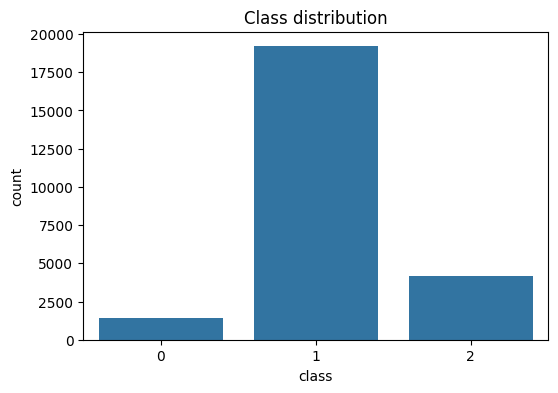

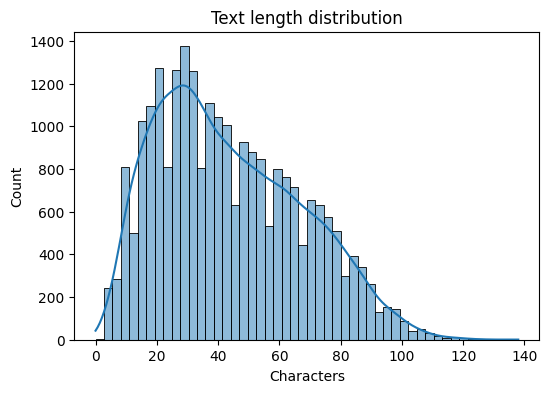

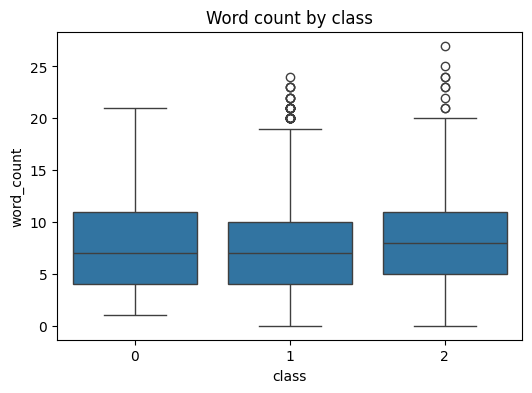

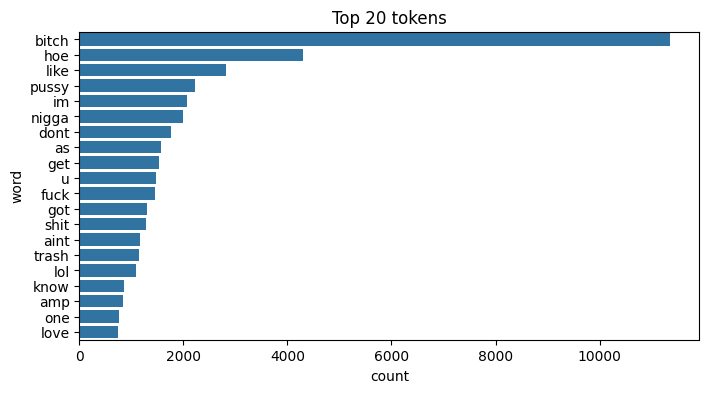

In [4]:
from collections import Counter

eda_df = df.copy()
if "clean_tweet" not in eda_df.columns and "tweet" in eda_df.columns:
    eda_df["clean_tweet"] = eda_df["tweet"].astype(str)

eda_df["text_len"] = eda_df["clean_tweet"].astype(str).str.len()
eda_df["word_count"] = eda_df["clean_tweet"].astype(str).str.split().apply(len)

plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x="class")
plt.title("Class distribution")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(eda_df["text_len"], bins=50, kde=True)
plt.title("Text length distribution")
plt.xlabel("Characters")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=eda_df, x="class", y="word_count")
plt.title("Word count by class")
plt.show()

tokens = " ".join(eda_df["clean_tweet"].astype(str)).split()
top_words = Counter(tokens).most_common(20)
top_df = pd.DataFrame(top_words, columns=["word", "count"])

plt.figure(figsize=(8, 4))
sns.barplot(data=top_df, x="count", y="word")
plt.title("Top 20 tokens")
plt.show()

## Hyperparameter tuning log
Track model settings and outcomes for reproducibility.

In [5]:
tuning_log = pd.DataFrame([
    {"setting": "Baseline GRU", "details": "GRU(128), dropout=0.3, class_weight, 6 epochs", "macro_f1": 0.1667},
    {"setting": "Balanced + BiGRU + focal", "details": "upsample + BiGRU(128) + focal loss + SpatialDropout", "macro_f1": None},
])
display(tuning_log)

,setting,details,macro_f1
0,Baseline GRU,"GRU(128), dropout=0.3, class_weight, 6 epochs",0.1667
1,Balanced + BiGRU + focal,upsample + BiGRU(128) + focal loss + SpatialDr...,NaN


In [6]:
# Balance classes by upsampling minority classes
df_balanced = df.copy()
class_col = "class"

dfs = []
max_size = df_balanced[class_col].value_counts().max()
for cls, group in df_balanced.groupby(class_col):
    dfs.append(resample(group, replace=True, n_samples=max_size, random_state=42))
df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Original class distribution:")
display(df[class_col].value_counts())

print("Balanced class distribution:")
display(df_balanced[class_col].value_counts())

Original class distribution:


class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Balanced class distribution:


class
1    19190
2    19190
0    19190
Name: count, dtype: int64

## GRU experiments: Skip-gram, CBOW, and GloVe embeddings
Let's  keep the preprocessing consistent across embeddings and only change how word vectors are obtained. This will supports fair comparison across embedding-model combinations.

## GRU with TF-IDF features
I am using a GRU over dense TF-IDF vectors to provide a consistent non-embedding baseline for comparison.

In [7]:
# TF-IDF features (sequence of top features)
data_df = df_balanced if "df_balanced" in globals() else df
if "clean_tweet" not in data_df.columns and "tweet" in data_df.columns:
    data_df["clean_tweet"] = data_df["tweet"].astype(str)

labels = data_df["class"].astype(int).to_numpy()
results = results if "results" in globals() else []

max_features = 5000
tfidf_texts = data_df["clean_tweet"].astype(str)
vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(tfidf_texts)

# Convert each TF-IDF row to a sequence of feature indices (sorted by weight)
top_k = 100
indices = np.argsort(-X_tfidf.toarray(), axis=1)[:, :top_k]
X_tfidf_seq = indices
y_tfidf = tf.keras.utils.to_categorical(labels, num_classes=3)

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_tfidf_seq, y_tfidf, test_size=0.2, random_state=42, stratify=labels
 )

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1.0 - y_pred, gamma)
        return tf.reduce_sum(weight * cross_entropy, axis=-1)
    return loss

def train_eval_gru_tfidf(Xtr, Xva, ytr, yva, name):
    model = Sequential([
        Embedding(input_dim=max_features + 1, output_dim=128, input_length=top_k),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.2)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="softmax"),
    ])
    model.compile(optimizer="adam", loss=focal_loss(gamma=2.0, alpha=0.25), metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5),
    ]
    model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=8,
        batch_size=64,
        verbose=2,
    )
    y_pred = np.argmax(model.predict(Xva, verbose=0), axis=1)
    y_true = np.argmax(yva, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    print(f"{name} | accuracy={acc:.4f} | macro_f1={f1:.4f}")
    return {"model": name, "accuracy": acc, "macro_f1": f1, "confusion_matrix": cm}

tfidf_result = train_eval_gru_tfidf(X_train_t, X_val_t, y_train_t, y_val_t, "GRU + TF-IDF")
results.append(tfidf_result)

/home/pauline/Documents/textclassification_GRU/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2026-02-06 11:57:42.875484: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/8
720/720 - 82s - 114ms/step - accuracy: 0.8632 - loss: 0.0324 - val_accuracy: 0.9476 - val_loss: 0.0133
Epoch 2/8
720/720 - 78s - 109ms/step - accuracy: 0.9538 - loss: 0.0110 - val_accuracy: 0.9649 - val_loss: 0.0095
Epoch 3/8
720/720 - 79s - 109ms/step - accuracy: 0.9699 - loss: 0.0072 - val_accuracy: 0.9689 - val_loss: 0.0082
Epoch 4/8
720/720 - 80s - 111ms/step - accuracy: 0.9778 - loss: 0.0052 - val_accuracy: 0.9756 - val_loss: 0.0073
Epoch 5/8
720/720 - 80s - 111ms/step - accuracy: 0.9811 - loss: 0.0044 - val_accuracy: 0.9743 - val_loss: 0.0087
Epoch 6/8
720/720 - 80s - 111ms/step - accuracy: 0.9844 - loss: 0.0037 - val_accuracy: 0.9729 - val_loss: 0.0097
Epoch 7/8
720/720 - 85s - 118ms/step - accuracy: 0.9859 - loss: 0.0031 - val_accuracy: 0.9775 - val_loss: 0.0087
Epoch 8/8
720/720 - 79s - 109ms/step - accuracy: 0.9872 - loss: 0.0030 - val_accuracy: 0.9804 - val_loss: 0.0093
GRU + TF-IDF | accuracy=0.9804 | macro_f1=0.9803


In [8]:
# Prepare data for GRU experiments
tf.random.set_seed(42)
np.random.seed(42)

data_df = df_balanced if "df_balanced" in globals() else df
texts = data_df["clean_tweet"] if "clean_tweet" in data_df.columns else data_df["tweet"].astype(str)
labels = data_df["class"].astype(int).to_numpy()

num_words = 30000
max_len = 120
embedding_dim = 100

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
 )
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val_raw, num_classes=3)

class_counts = np.bincount(labels, minlength=3)
class_weights = {i: (len(labels) / (3 * count)) for i, count in enumerate(class_counts)}

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1.0 - y_pred, gamma)
        return tf.reduce_sum(weight * cross_entropy, axis=-1)
    return loss

def build_embedding_matrix(word_index, embedding_lookup, dim, max_words):
    matrix = np.zeros((max_words + 1, dim))
    for word, idx in word_index.items():
        if idx > max_words:
            continue
        if word in embedding_lookup:
            matrix[idx] = embedding_lookup[word]
    return matrix

def train_eval_gru(embedding_matrix, name):
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            input_length=max_len,
            weights=[embedding_matrix],
            trainable=True,
        ),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.2)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="softmax"),
    ])
    model.compile(optimizer="adam", loss=focal_loss(gamma=2.0, alpha=0.25), metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5),
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8,
        batch_size=64,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=2,
    )
    y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    acc = accuracy_score(y_val_raw, y_pred)
    f1 = f1_score(y_val_raw, y_pred, average="macro")
    cm = confusion_matrix(y_val_raw, y_pred)
    print(f"{name} | accuracy={acc:.4f} | macro_f1={f1:.4f}")
    return {"model": name, "accuracy": acc, "macro_f1": f1, "confusion_matrix": cm}

In [9]:
# Train Word2Vec (Skip-gram)
tokenized = [t.split() for t in texts]
results = []

w2v_skip = gensim.models.Word2Vec(
    sentences=tokenized,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10,
)
skip_matrix = build_embedding_matrix(tokenizer.word_index, w2v_skip.wv, embedding_dim, num_words)
results.append(train_eval_gru(skip_matrix, "GRU + Word2Vec (Skip-gram)"))

Epoch 1/8


/home/pauline/Documents/textclassification_GRU/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


720/720 - 99s - 137ms/step - accuracy: 0.7714 - loss: 0.0525 - val_accuracy: 0.8783 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 2/8
720/720 - 96s - 134ms/step - accuracy: 0.8737 - loss: 0.0278 - val_accuracy: 0.9283 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 3/8
720/720 - 98s - 137ms/step - accuracy: 0.9199 - loss: 0.0169 - val_accuracy: 0.9544 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 4/8
720/720 - 96s - 133ms/step - accuracy: 0.9446 - loss: 0.0117 - val_accuracy: 0.9633 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/8
720/720 - 96s - 133ms/step - accuracy: 0.9606 - loss: 0.0084 - val_accuracy: 0.9667 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 6/8
720/720 - 106s - 148ms/step - accuracy: 0.9684 - loss: 0.0066 - val_accuracy: 0.9732 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 7/8
720/720 - 95s - 133ms/step - accuracy: 0.9729 - loss: 0.0056 - val_accuracy: 0.9807 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 8/8
720/720 - 92s - 128ms/step - accuracy: 0

In [10]:
# Train Word2Vec (CBOW)
w2v_cbow = gensim.models.Word2Vec(
    sentences=tokenized,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10,
)
cbow_matrix = build_embedding_matrix(tokenizer.word_index, w2v_cbow.wv, embedding_dim, num_words)
results.append(train_eval_gru(cbow_matrix, "GRU + Word2Vec (CBOW)"))

Epoch 1/8


/home/pauline/Documents/textclassification_GRU/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


720/720 - 102s - 141ms/step - accuracy: 0.7823 - loss: 0.0501 - val_accuracy: 0.8762 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 2/8
720/720 - 117s - 163ms/step - accuracy: 0.8817 - loss: 0.0267 - val_accuracy: 0.9377 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 3/8
720/720 - 95s - 132ms/step - accuracy: 0.9293 - loss: 0.0155 - val_accuracy: 0.9573 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 4/8
720/720 - 93s - 130ms/step - accuracy: 0.9496 - loss: 0.0108 - val_accuracy: 0.9600 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 5/8
720/720 - 97s - 135ms/step - accuracy: 0.9633 - loss: 0.0080 - val_accuracy: 0.9734 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 6/8
720/720 - 97s - 134ms/step - accuracy: 0.9705 - loss: 0.0064 - val_accuracy: 0.9731 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 7/8
720/720 - 98s - 136ms/step - accuracy: 0.9747 - loss: 0.0053 - val_accuracy: 0.9779 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 8/8
720/720 - 100s - 139ms/step - accuracy:

In [11]:
# Train GRU with GloVe embeddings
glove = api.load("glove-wiki-gigaword-50")
glove_matrix = build_embedding_matrix(tokenizer.word_index, glove, glove.vector_size, num_words)
results.append(train_eval_gru(glove_matrix, "GRU + GloVe (50d)"))

Epoch 1/8


/home/pauline/Documents/textclassification_GRU/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


720/720 - 90s - 125ms/step - accuracy: 0.7153 - loss: 0.0635 - val_accuracy: 0.8350 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 2/8
720/720 - 89s - 123ms/step - accuracy: 0.8303 - loss: 0.0377 - val_accuracy: 0.8750 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 3/8
720/720 - 91s - 126ms/step - accuracy: 0.8697 - loss: 0.0275 - val_accuracy: 0.9135 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 4/8
720/720 - 85s - 118ms/step - accuracy: 0.8976 - loss: 0.0211 - val_accuracy: 0.9292 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 5/8
720/720 - 80s - 112ms/step - accuracy: 0.9187 - loss: 0.0165 - val_accuracy: 0.9460 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 6/8
720/720 - 80s - 111ms/step - accuracy: 0.9338 - loss: 0.0139 - val_accuracy: 0.9568 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 7/8
720/720 - 85s - 118ms/step - accuracy: 0.9447 - loss: 0.0114 - val_accuracy: 0.9610 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 8/8
720/720 - 78s - 109ms/step - accuracy: 0.

,model,accuracy,macro_f1
0,GRU + Word2Vec (Skip-gram),0.980719,0.980629
1,GRU + Word2Vec (CBOW),0.977853,0.977769
2,GRU + GloVe (50d),0.963610,0.963248


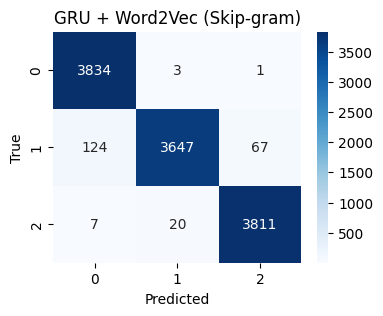

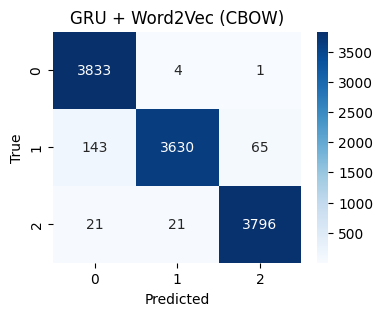

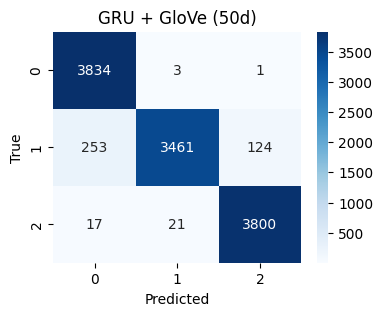

In [12]:
# Results table and confusion matrices
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != "confusion_matrix"} for r in results])
display(results_df)

for r in results:
    plt.figure(figsize=(4, 3))
    sns.heatmap(r["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(r["model"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

The skip gram is working better that the cbow and glove